# Implementing a Neural Network from Scratch - An Introduction

In this post we will implement a simple 3-layer neural network from scratch. We won't derive all the math that's required, but I will try to give an intuitive explanation of what we are doing and will point to resources to read up on the details.

In this post I'm assuming that you are familiar with basic Calculus and Machine Learning concepts, e.g. you know what classification and regularization is. Ideally you also know a bit about how optimization techniques like gradient descent work. But even if you're not familiar with any of the above this post could still turn out to be interesting ;)

But why implement a Neural Network from scratch at all? Even if you plan on using Neural Network libraries like [PyBrain](http://pybrain.org) in the future, implementing a network from scratch at least once is an extremely valuable exercise. It helps you gain an understanding of how neural networks work, and that is essential to designing effective models.

One thing to note is that the code examples here aren't terribly efficient. They are meant to be easy to understand. In an upcoming post I will explore how to write an efficient Neural Network implementation using [Theano](http://deeplearning.net/software/theano/). 

In [45]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## Generating a dataset

Let's start by generating a dataset we can play with. Fortunately, [scikit-learn](http://scikit-learn.org/) has some useful dataset generators, so we don't need to write the code ourselves. We will go with the [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.

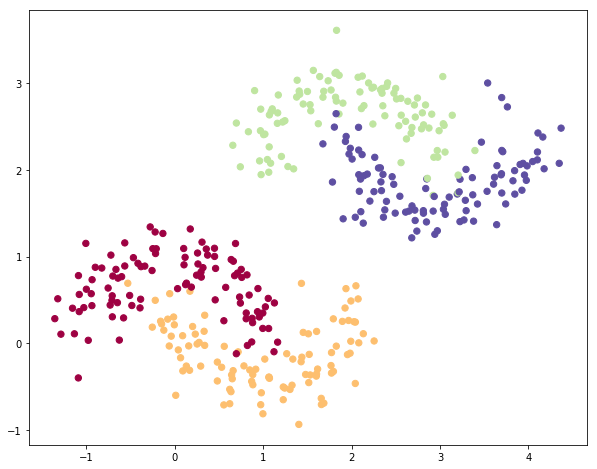

In [46]:
# Generate a dataset and plot it
np.random.seed(0)

def make_n_moon_pairs(n_pairs=1, offset_increment_x=2, offset_increment_y=2, count=200, noise=0.2):
    offset_x = 0
    offset_y = 0
    offset_colour = 0
    coords = []
    colours = []
    for i in range(0, n_pairs):
        coords_i, colours_i = sklearn.datasets.make_moons(count, noise=noise)
        coords.append(coords_i + [offset_x, offset_y])
        colours.append(colours_i + offset_colour)        
        offset_x += offset_increment_x
        offset_y += offset_increment_y
        offset_colour += 2
    return np.concatenate(coords), np.concatenate(colours)

#X, y = sklearn.datasets.make_moons(500, noise=0.20)
X, y = make_n_moon_pairs(2)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)


The dataset we generated has two classes, plotted as red and blue points. You can think of the blue dots as male patients and the red dots as female patients, with the x- and y- axis being medical measurements. 

Our goal is to train a Machine Learning classifier that predicts the correct class (male or female) given the x- and y- coordinates. Note that the data is not *linearly separable*, we can't draw a straight line that separates the two classes. This means that linear classifiers, such as Logistic Regression, won't be able to fit the data unless you hand-engineer non-linear features (such as polynomials) that work well for the given dataset.

In fact, that's one of the major advantages of Neural Networks. You don't need to worry about [feature engineering](http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/). The hidden layer of a neural network will learn features for you.

## Logistic Regression

To demonstrate the point let's train a Logistic Regression classifier. It's input will be the x- and y-values and the output the predicted class (0 or 1). To make our life easy we use the Logistic Regression class from `scikit-learn`.

In [47]:
# Train the logistic regeression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [73]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    padding_ratio = 0.1
    
    x_pad = x_range * padding_ratio
    y_pad = y_range * padding_ratio
    
    x_h = x_range / 1000
    y_h = y_range / 1000
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(
        np.arange(x_min - x_pad, x_max + x_pad, x_h),
        np.arange(y_min - y_pad, y_max + y_pad, y_h)
    )
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

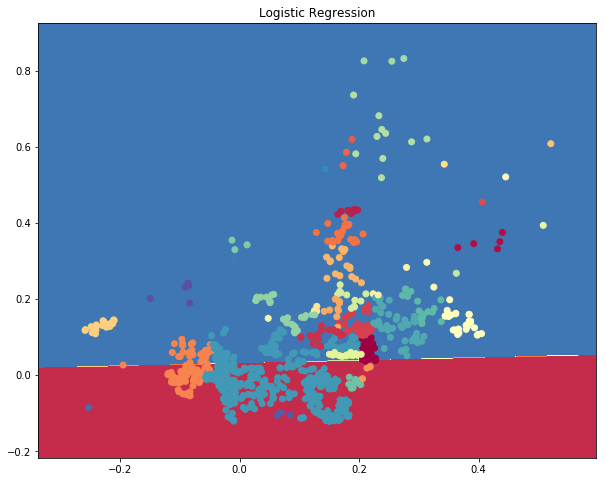

In [67]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x), X, y)
plt.title("Logistic Regression")

The graph shows the decision boundary learned by our Logistic Regression classifier. It separates the data as good as it can using a straight line, but it's unable to capture the "moon shape" of our data.

## Training a Neural Network

Let's now build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data, 2. Similarly, the number of nodes in the output layer is determined by the number of classes we have, also 2. (Because we only have 2 classes we could actually get away with only one output node predicting 0 or 1, but having 2 makes it easier to extend the network to more classes later on). The input to the network will be x- and y- coordinates and its output will be two probabilities, one for class 0 ("female") and one for class 1 ("male"). It looks something like this:

<img src='./nn-3-layer-network.png' style='width: 50%'/>

We can choose the dimensionality (the number of nodes) of the hidden layer. The more nodes we put into the hidden layer the more complex functions we will be able fit. But higher dimensionality comes at a cost. First, more computation is required to make predictions and learn the network parameters. A bigger number of parameters also means we become more prone to overfitting our data. 

How to choose the size of the hidden layer? While there are some general guidelines and recommendations, it always depends on your specific problem and is more of an art than a science. We will play with the number of nodes in the hidden later later on and see how it affects our output.

We also need to pick an *activation function* for our hidden layer. The activation function transforms the inputs of the layer into its outputs. A nonlinear activation function is what allows us to fit nonlinear hypotheses. Common chocies for activation functions are [tanh](https://reference.wolfram.com/language/ref/Tanh.html), the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function), or [ReLUs](https://en.wikipedia.org/wiki/Rectifier_(neural_networks). We will use `tanh`, which performs quite well in many scenarios. A nice property of these functions is that their derivate can be computed using the original function value. For example, the derivative of $\tanh x$ is $1-\tanh^2 x$. This is useful because it allows us to compute $\tanh x$ once and re-use its value later on to get the derivative.

Because we want our network to output probabilities the activation function for the output layer will be the [softmax](https://en.wikipedia.org/wiki/Softmax_function), which is simply a way to convert raw scores to probabilities. If you're familiar with the logistic function you can think of softmax as its generalization to multiple classes.

### How our network makes predictions

Our network makes predictions using *forward propagation*, which is just a bunch of matrix multiplications and the application of the activation function(s) we defined above. If $x$ is the 2-dimensional input to our network then we calculate our prediction $\hat{y}$ (also two-dimensional) as follows:

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

$z_i$ is the input of layer $i$ and $a_i$ is the output of layer $i$ after applying the activation function. $W_1, b_1, W_2, b_2$ are  parameters of our network, which we need to learn from our training data. You can think of them as matrices transforming data between layers of the network. Looking at the matrix multiplications above we can figure out the dimensionality of these matrices. If we use 500 nodes for our hidden layer then $W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$. Now you see why we have more parameters if we increase the size of the hidden layer.

### Learning the Parameters

Learning the parameters for our network means finding parameters ($W_1, b_1, W_2, b_2$) that minimize the error on our training data. But how do we define the error? We call the function that measures our error the *loss function*. A common choice with the softmax output is the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression). If we have $N$ training examples and $C$ classes then the loss for our prediction $\hat{y}$ with respect to the true labels $y$ is given by:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$



The formula looks complicated, but all it really does is sum over our training examples and add to the loss if we predicted the incorrect class. So, the further away $y$ (the correct labels) and $\hat{y}$ (our predictions) are, the greater our loss will be. 

Remember that our goal is to find the parameters that minimize our loss function. We can use [gradient descent](http://cs231n.github.io/optimization-1/) to find its minimum. I will implement the most vanilla version of gradient descent, also called batch gradient descent with a fixed learning rate. Variations such as SGD (stochastic gradient descent) or minibatch gradient descent typically perform better in practice. So if you are serious you'll want to use one of these, and ideally you would also [decay the learning rate over time](http://cs231n.github.io/neural-networks-3/#anneal).

As an input, gradient descent needs the gradients (vector of derivatives) of the loss function with respect to our parameters: $\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}}$. To calculate these gradients we use the famous *backpropagation algorithm*, which is a way to efficiently calculate the gradients starting from the output. I won't go into detail how backpropagation works, but there are many excellent explanations ([here](http://colah.github.io/posts/2015-08-Backprop/) or [here](http://cs231n.github.io/optimization-2/)) floating around the web.

Applying the backpropagation formula we find the following (trust me on this):

$$
\begin{aligned}
& \delta_3 = \hat{y} - y \\
& \delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

### Implementation

Now we are ready for our implementation. We start by defining some useful variables and parameters for gradient descent:

In [50]:
# Gradient descent parameters (I picked these by hand)
reg_lambda = 0.01 # regularization strength

def calculate_epsilon_exponential(iteration, num_passes):
    start = 0.1
    end = 0.001
    
    exp = (float(iteration) / num_passes) * 10
    
    subtract_proportion = 1 - (1.0 / (1.5 ** exp))
    return start - ((start - end) * subtract_proportion)

def calculate_epsilon_original(iteration, num_passes):
    return 0.01

def calculate_epsilon_inverse_exponential(iteration, num_passes):
    start = 0.01
    base = 1.0001
    
    return start - (start * ((base ** iteration) / (base ** num_passes)))

def calculate_epsilon(iteration, num_passes):
    return calculate_epsilon_inverse_exponential(iteration, num_passes)
#     return 0.01

def activation(dataset, input_layer, bias):
    z1 = dataset.dot(input_layer) + bias
    return np.tanh(z1)

def activation_derivative(z1):
    return (1 - np.power(a1, 2))

def forward_propagation(model, dataset, a_fn=activation):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    a1 = a_fn(dataset, W1, b1)
    z2 = a1.dot(W2) + b2
    
    exp_scores = np.exp(z2)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def sample_training_data(X, y, n):
    indices = np.random.choice(len(X), n, replace=False)
    return X[(indices),], y[(indices),]
    

First let's implement the loss function we defined above. We use this to evaluate how well our model is doing:

In [51]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model, X, y):
    probs = forward_propagation(model, X)
    # Calculating the loss
    correct_logprobs = -np.log(probs[range(len(X)), y])
    data_loss = np.sum(correct_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(model['W1'])) + np.sum(np.square(model['W2'])))
    return 1./len(X) * data_loss

We also implement a helper function to calculate the output of the network. It does forward propagation as defined above and returns the class with the highest probability.

In [52]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    probs = forward_propagation(model, x)
    return np.argmax(probs, axis=1)

Finally, here comes the function to train our Neural Network. It implements batch gradient descent using the backpropagation derivates we found above.

In [69]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(X, y, nn_hdim, num_passes=100000, minibatch_size=16, print_loss=False):
    
    nn_input_dim = X.shape[1] # input layer dimensionality
    nn_output_dim = np.unique(y).size

    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(num_passes):
        sample_X, sample_y = sample_training_data(X, y, minibatch_size)
        
        a1 = activation(sample_X, W1, b1)
        probs = forward_propagation(dict(W1=W1, b1=b1, W2=W2, b2=b2), sample_X, lambda *args: a1)

        # Backpropagation
        delta3 = probs
        delta3[range(len(sample_X)), sample_y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(sample_X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        epsilon = calculate_epsilon(i, num_passes)
        
        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
            print(f'Loss after iteration {i}: {calculate_loss(model, X, y)} (epsilon: {epsilon})')

    if print_loss:
        print(f'Loss after final iteration {i}: {calculate_loss(model, X, y)} (epsilon: {calculate_epsilon(num_passes, num_passes)})')
    
    return model

### A network with a hidden layer of size 3

Let's see what happens if we train a network with a hidden layer size of 3.


Loss after iteration 0: 3.689741467502856 (epsilon: 0.009999545773661106)
Loss after iteration 1000: 1.5960705434227076 (epsilon: 0.009999498004769847)
Loss after iteration 2000: 1.2900264840833011 (epsilon: 0.009999445212244381)
Loss after iteration 3000: 1.1396581399068444 (epsilon: 0.00999938686777225)
Loss after iteration 4000: 1.0491154190617737 (epsilon: 0.009999322387480802)
Loss after iteration 5000: 0.9993113075690225 (epsilon: 0.009999251126094188)
Loss after iteration 6000: 0.9641920871019279 (epsilon: 0.009999172370475873)
Loss after iteration 7000: 0.939867522488214 (epsilon: 0.009999085332492037)
Loss after iteration 8000: 0.9124029117593899 (epsilon: 0.009998989141124461)
Loss after iteration 9000: 0.9055412237078906 (epsilon: 0.009998882833753948)
Loss after iteration 10000: 0.8878957126212826 (epsilon: 0.00999876534652708)
Loss after iteration 11000: 0.8753872314775096 (epsilon: 0.009998635503709871)
Loss after iteration 12000: 0.8723425992681774 (epsilon: 0.0099984920

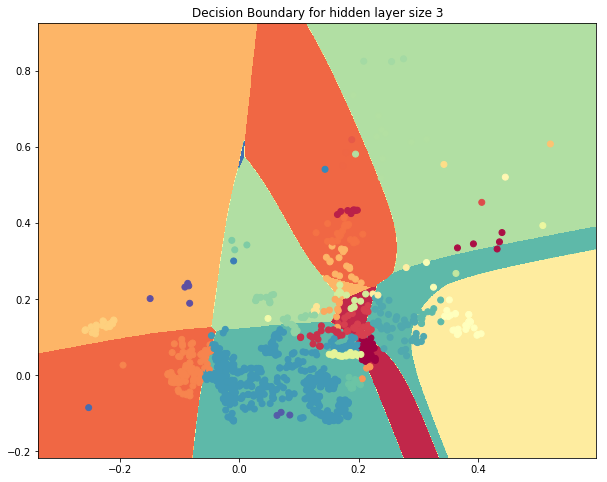

In [74]:
# Build a model with a n-dimensional hidden layer
layer_size = 3
model = build_model(X, y, layer_size, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x), X, y)
plt.title("Decision Boundary for hidden layer size {}".format(str(layer_size)))

Yay! This looks pretty good. Our neural networks was able to find a decision boundary that successfully separates the classes.

# Varying the hidden layer size

In the example above we picked a hidden layer size of 3. Let's now get a sense of how varying the hidden layer size affects the result.


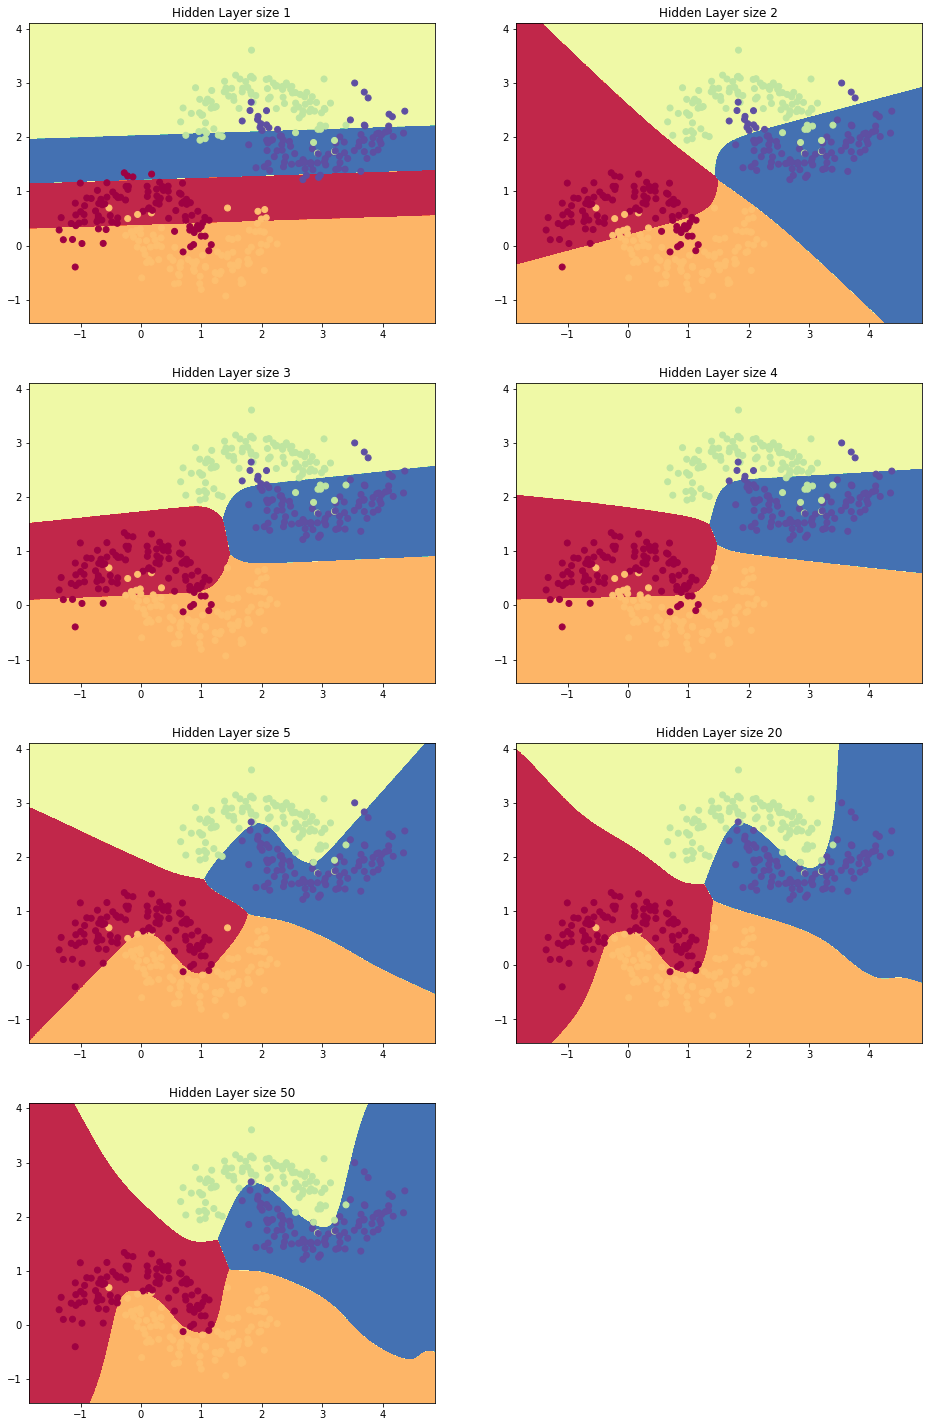

In [55]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
#hidden_layer_dimensions = [1]
#hidden_layer_dimensions = [4, 5, 6]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(X, y, nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x), X, y)
plt.show()

We can see that while a hidden layer of low dimensionality nicely capture the general trend of our data, but higher dimensionalities are prone to overfitting. They are "memorizing" the data as opposed to fitting the general shape. If we were to evaluate our model on a separate test set (and you should!) the model with a smaller hidden layer size would likely perform better because it generalizes better. We could counteract overfitting with stronger regularization, but picking the a correct size for hidden layer is a much more "economical" solution.

# Exercises

Here are some things you can try to become more familiar with the code:

1. Instead of batch gradient descent, use minibatch gradient descent ([more info](http://cs231n.github.io/optimization-1/#gd)) to train the network. Minibatch gradient descent typically performs better in practice. 
2. We used a fixed learning rate $\epsilon$ for gradient descent. Implement an annealing schedule for the gradient descent learning rate ([more info](http://cs231n.github.io/neural-networks-3/#anneal)). - DONE
3. We used a $\tanh$ activation function for our hidden layer. Experiment with other activation functions (some are mentioned above). Note that changing the activation function also means changing the backpropagation derivative.
4. Extend the network from two to three classes. You will need to generate an appropriate dataset for this.
5. Extend the network to four layers. Experiment with the layer size. Adding another hidden layer means you will need to adjust both the forward propagation as well as the backpropagation code.

# Todo

1. Continue changing the activation function (exercise 3)


In [56]:
X.shape[1]

2

In [61]:
sacramento_dtypes = {
    'names': ('city', 'lat', 'lon'),
    'formats': ('S100', 'float', 'float')
}
sacramento_txns = np.loadtxt('sacramento_real_estate_transactions.csv', delimiter=',', usecols=(1,10,11), skiprows=1, dtype=sacramento_dtypes)

y_strings = np.array([txn[0] for txn in sacramento_txns])
X = np.array([[txn[1] - 38.5, txn[2] + 121.43] for txn in sacramento_txns])

y_unique = np.unique(y_strings)
list1, list2 = y_unique, range(len(y_unique))
y_dict = dict( zip( list1, list2))
# y_dict = { b'SACRAMENTO': 0 }
y = np.array([y_dict.get(city, 1) for city in y_strings])



print(y_unique)
print(X[0:5])
print(y[0:5])

[b'ANTELOPE' b'AUBURN' b'CAMERON PARK' b'CARMICHAEL' b'CITRUS HEIGHTS'
 b'COOL' b'DIAMOND SPRINGS' b'EL DORADO' b'EL DORADO HILLS' b'ELK GROVE'
 b'ELVERTA' b'FAIR OAKS' b'FOLSOM' b'FORESTHILL' b'GALT' b'GARDEN VALLEY'
 b'GOLD RIVER' b'GRANITE BAY' b'GREENWOOD' b'LINCOLN' b'LOOMIS' b'MATHER'
 b'MEADOW VISTA' b'NORTH HIGHLANDS' b'ORANGEVALE' b'PENRYN' b'PLACERVILLE'
 b'POLLOCK PINES' b'RANCHO CORDOVA' b'RANCHO MURIETA' b'RIO LINDA'
 b'ROCKLIN' b'ROSEVILLE' b'SACRAMENTO' b'SHINGLE SPRINGS' b'SLOUGHHOUSE'
 b'WALNUT GROVE' b'WEST SACRAMENTO' b'WILTON']
[[ 0.131913 -0.004879]
 [-0.021098 -0.001028]
 [ 0.118305 -0.013839]
 [ 0.116835 -0.009146]
 [ 0.01947  -0.005768]]
[33 33 33 33 33]


Loss after iteration 0: 3.194898555362285 (epsilon: 0.009999545773661106)
Loss after iteration 1000: 0.612253985395844 (epsilon: 0.009999498004769847)
Loss after iteration 2000: 0.5027045061267273 (epsilon: 0.009999445212244381)
Loss after iteration 3000: 0.41816177599397264 (epsilon: 0.00999938686777225)
Loss after iteration 4000: 0.4162198276354342 (epsilon: 0.009999322387480802)
Loss after iteration 5000: 0.3590179309491651 (epsilon: 0.009999251126094188)
Loss after iteration 6000: 0.3548394929129552 (epsilon: 0.009999172370475873)
Loss after iteration 7000: 0.3433462701505333 (epsilon: 0.009999085332492037)
Loss after iteration 8000: 0.30250228352762104 (epsilon: 0.009998989141124461)
Loss after iteration 9000: 0.2873492892212088 (epsilon: 0.009998882833753948)
Loss after iteration 10000: 0.286870619514433 (epsilon: 0.00999876534652708)
Loss after iteration 11000: 0.2929332592685157 (epsilon: 0.009998635503709871)
Loss after iteration 12000: 0.26240399719653634 (epsilon: 0.00999849

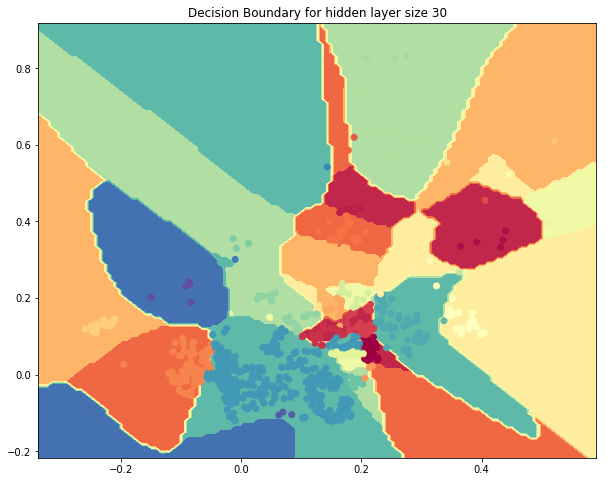

In [72]:
layer_size = 30
model = build_model(X, y, layer_size, print_loss=True, minibatch_size=128, num_passes=100000)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x), X, y)
plt.title("Decision Boundary for hidden layer size {}".format(str(layer_size)))

In [59]:
probs = forward_propagation(model, np.array([39.4, -127]))
res = predict(model, np.array([39.4, -127]))
[probs, res]

[array([[  9.99999999e-01,   1.00312807e-09]]), array([0])]

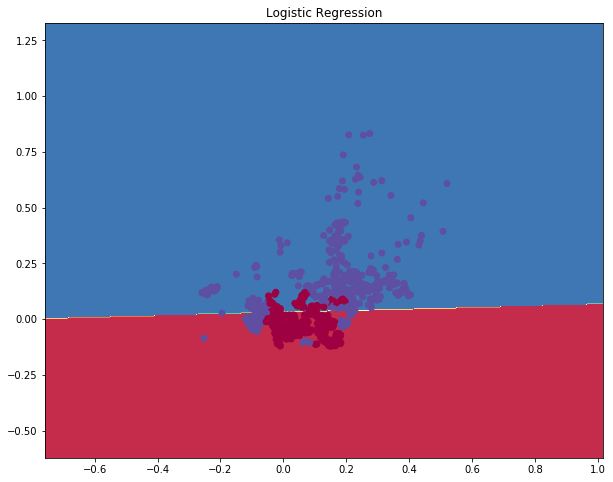

In [60]:
# Train the logistic regeression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x), X, y)
plt.title("Logistic Regression")